<a href="https://colab.research.google.com/github/jpdeleon/chronos/blob/master/notebooks/examples-transit_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install git+https://github.com/jpdeleon/chronos.git@master

In [2]:
import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Initialize light curve

In [3]:
toiid = 1257
s=cr.ShortCadence(toiid=toiid)
s

Target: TOI 1257
Available sectors: [14]
Using sector=14.


ShortCadence(mission=tess, toiid=1257, ticid=278348461, target_name=TOI 1257, target_coord=(303.195,18.1048), all_sectors=[14], search_radius=3.0 arcsec, sector=14, sap_mask=pipeline, aper_radius=1, percentile=95, threshold_sigma=5, quality_bitmask=default, apply_data_quality_mask=False, calc_fpp=False, apphot_method=aperture)

In [4]:
#download PDCSAP lc
lc = s.get_lc(lctype='pdcsap')

Searching lightcurvefile for TIC 278348461 (sector 14)
Found 1 lightcurves


Using period=5.4528 d, epoch=1686.83 BTJD, duration=3.53 hr
Using biweight filter with window_length=0.44 day


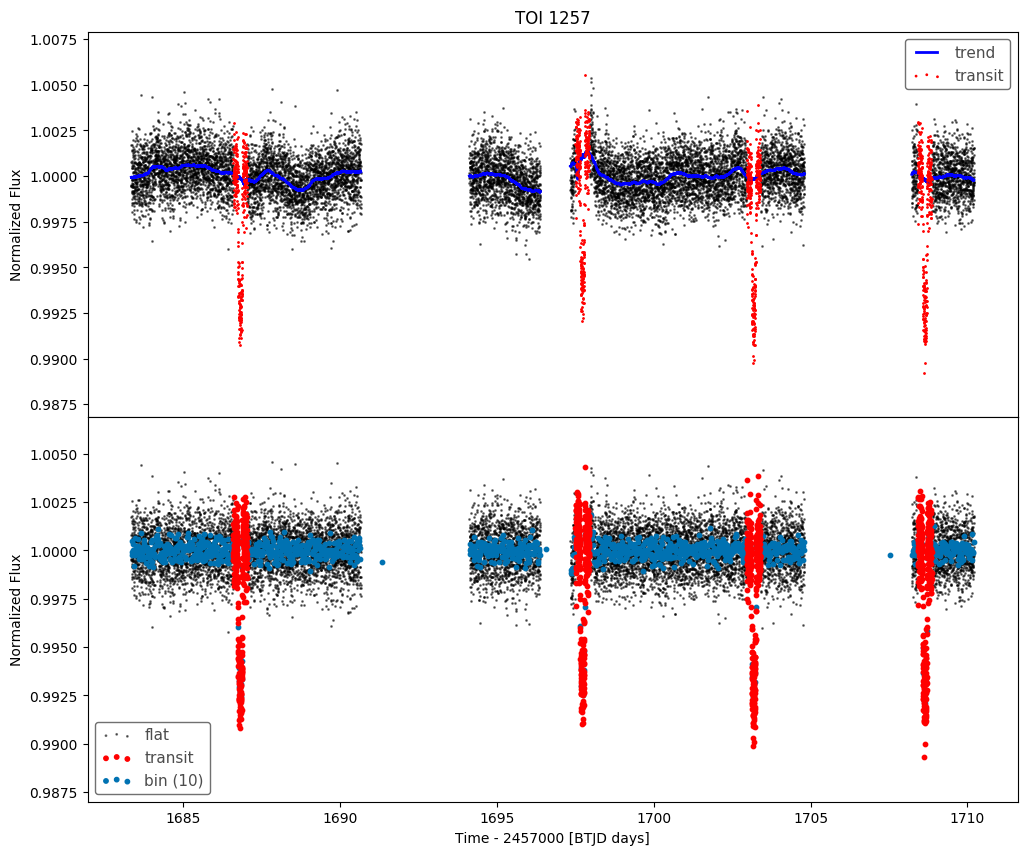

In [5]:
#plot raw, trend and flattened lc
#transits are automatically masked if TOI ephemeris is known
fig = s.plot_trend_flat_lcs(lc)

Using biweight filter with window_length=0.44 day


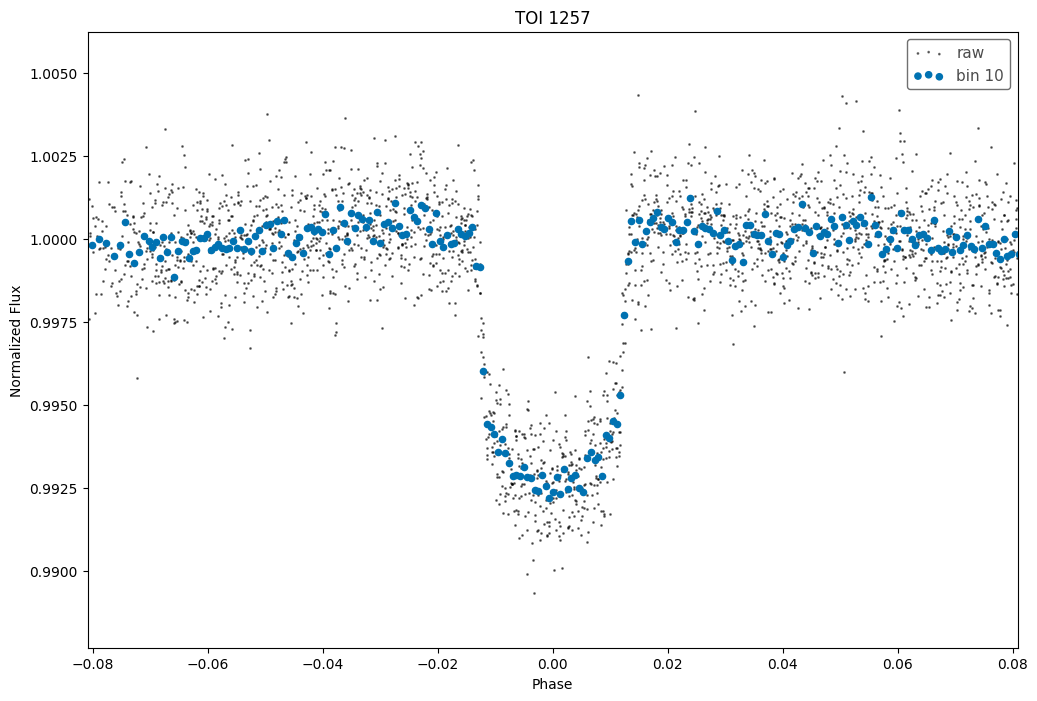

In [6]:
flat = s.get_flat_lc(lc)

#plot folded lc
ax = s.plot_fold_lc(flat)

## TLS periodogram

Transit Least Squares TLS 1.0.23 (12 March 2019)


  0%|          | 0/2442 periods | 00:00<?

Creating model cache for 28 durations
Searching 13610 data points, 2442 periods from 0.601 to 13.424 days
Using all 8 CPU threads


100%|██████████| 2442/2442 periods | 00:14<00:00


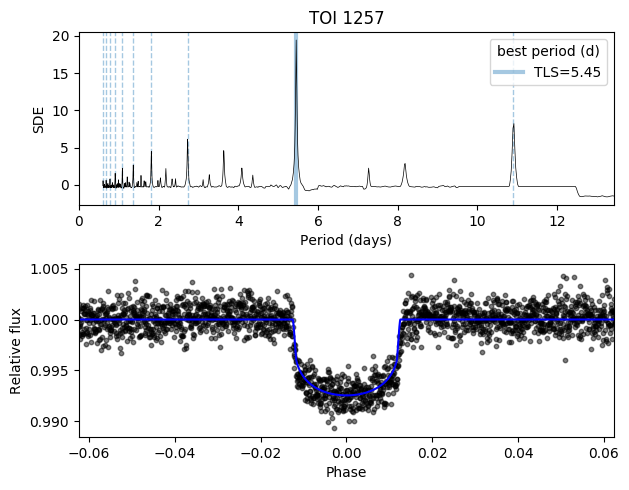

In [8]:
fig = s.run_tls(flat, plot=True)

In [9]:
s.tls_results

{'SDE': 19.406275761306855,
 'SDE_raw': 16.660011831794268,
 'chi2_min': 0.017001340494746765,
 'chi2red_min': 1.2495472949247953e-06,
 'period': 5.4522375830412155,
 'period_uncertainty': 0.02702803955865596,
 'T0': 1686.826742626134,
 'duration': 0.11327799991389509,
 'depth': 0.9925493323030189,
 'depth_mean': (0.9930211834925557, 6.852262719077278e-05),
 'depth_mean_even': (0.9931112966822677, 7.773567822925828e-05),
 'depth_mean_odd': (0.9927530689404491, 0.00013971853413601425),
 'transit_depths': array([0.99304903,        nan, 0.99341977, 0.99275307, 0.99287938]),
 'transit_depths_uncertainties': array([0.00011809,        nan, 0.00012822, 0.00013972, 0.00014802]),
 'rp_rs': 0.07762555957887499,
 'snr': 92.07086878030424,
 'snr_per_transit': array([45.99395096,  0.        , 42.7268661 , 47.95226934, 47.40640166]),
 'snr_pink_per_transit': array([48.23475158,  0.        , 45.66206796, 50.28847818, 49.41193978]),
 'odd_even_mismatch': 1.6473709013134958,
 'transit_times': [1686.826

## iterative masking and transit search